*Note: This is an adaptation of the notebook found in optical_flow repo, commit `b654828`, which in its original form works with sinabs from commit `3fafee4` and sinabs-slayer, commit `7114a11`*

This adaptation should work with sinabs and exodus in their most recent versions (25.02.2022) and is independent of the optical_flow project. 

# Why does slayer model not work?

This notebook will show that for the wheel-motion classification toy task, the same model architecture can be trained with exodus but training on slayer fails. We will try to explore why this is the case.

The notebook's code is based on the script `binary_task.py` from the optical_flow repo.

SPOILER:
The problem was exploding gradients in the slayer model. Enabling an option to scale down the surrogate gradients resolved it.
The problem can be reproduced by setting `kwargs_spiking["scale_grads"]` to 1 (second code cell), which corresponds to the original value.

In [ ]:
### --- Run this cell only to generate the data!
%run data_generation.py --size=256 --num_segments=4 --num_timesteps=300 --save_path=rotating_wedge_events.npy

In [1]:
### --- Imports

# Set this to inline or notebook if widget is not supported. Animation might not work then.
%matplotlib widget

import torch
from torch import nn
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.animation import FuncAnimation

from slayerSNN import loss as SpikeLoss

from sinabs.from_torch import from_model
from sinabs.utils import get_activations
import sinabs.layers as sl

from data import InvertDirDataset
from binary_models import SlayerModel, ExodusModel

(2, 256, 256, 300)


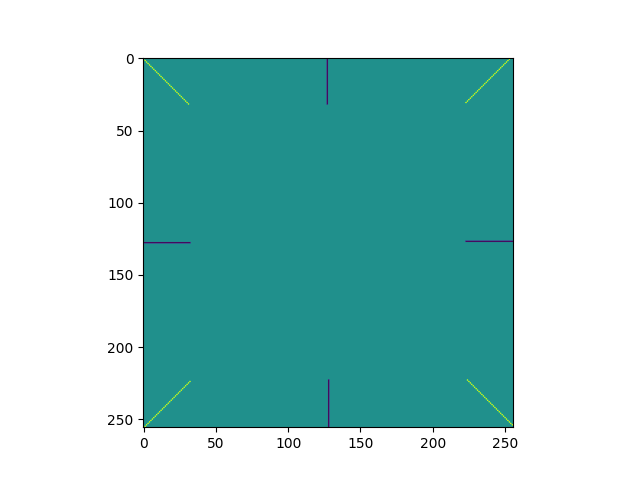

In [2]:
### --- Data loading and inspection
raster = np.load("rotating_wedge_events.npy").astype(np.float32)
raster = raster.transpose(1,2,3,0)
print(raster.shape)

raster_merged = (raster[1] - raster[0]).transpose(-1,0,1)
fig, ax = plt.subplots()
screen = ax.imshow(raster_merged[0], vmin=np.min(raster_merged), vmax=np.max(raster_merged))

def update_plot(frm):
    return screen.set_data(frm)

anim = FuncAnimation(fig, update_plot, frames=raster_merged)

In [3]:
### --- Settings and hyperparameters
lr = 1e-3
num_epochs = 40
optimizer_class = torch.optim.SGD  # torch.optim.Adam
downsample = 1
num_ts = raster.shape[-1] // downsample

# - Model parameters
kwargs_model = {
    "grad_width": 0.5,  # 0.5
    "grad_scale": 1,  # 0.02
    "thr": 1,
    "num_ts": num_ts,
    # "neuron_type": "LIF",
    # "tau_leak": 100,
}

In [4]:
# - Datset and loader
# Set sample_size and step_size such that each sample corresponds to all frames of one class
ds = InvertDirDataset(
    raster, sample_size=num_ts, step_size=num_ts, downsample=downsample
)
dl = torch.utils.data.DataLoader(ds, batch_size=1, shuffle=True)

# - Loss function
loss_func = torch.nn.CrossEntropyLoss()

# - Sinabs model
model_exodus = ExodusModel(**kwargs_model).cuda()
model_exodus.reset()
print("Sinabs model:")
print(model_exodus)

model_slayer = SlayerModel(**kwargs_model).cuda()
print("Slayer model:")
print(model_slayer)

Sinabs model:
ExodusModel(
  (pool0): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv0): Conv2d(2, 4, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk0): IAFSqueeze-module, backend: exodus
  (pool1): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (conv1): Conv2d(4, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3), bias=False)
  (spk1): IAFSqueeze-module, backend: exodus
  (pool2): AvgPool2d(kernel_size=4, stride=4, padding=0)
  (linear): Linear(in_features=128, out_features=2, bias=False)
)
Slayer model:
SlayerModel(
  (slayer): SlayerLayer()
  (pool0): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv0): _convLayer(2, 4, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool1): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride=(4, 4, 1), bias=False)
  (conv1): _convLayer(4, 8, kernel_size=(7, 7, 1), stride=(1, 1, 1), padding=(3, 3, 0), bias=False)
  (pool2): _poolLayer(1, 1, kernel_size=(4, 4, 1), stride

In [5]:
# - Transfer weights from exodus to slayer model to ensure same initial conditions
model_slayer.conv0.weight.data = model_exodus.conv0.weight.data.unsqueeze(-1).clone()
model_slayer.conv1.weight.data = model_exodus.conv1.weight.data.unsqueeze(-1).clone()
model_slayer.linear.weight.data = model_exodus.linear.weight.data.clone().reshape(2, 8, 4, 4, 1)

Now the two models should produce the same output for a given input. Let's make sure this is the case

In [6]:
# - Compare outputs before training
outputs_slayer = []
outputs_exodus = []

with torch.no_grad():
    # Load input from dataset to avoid shuffling.
    for inp, *__ in ds:
        # Add batch dimension
        inp = inp.unsqueeze(0).cuda()
        outputs_slayer.append(model_slayer(inp))
        outputs_exodus.append(model_exodus(inp))
        model_exodus.reset()

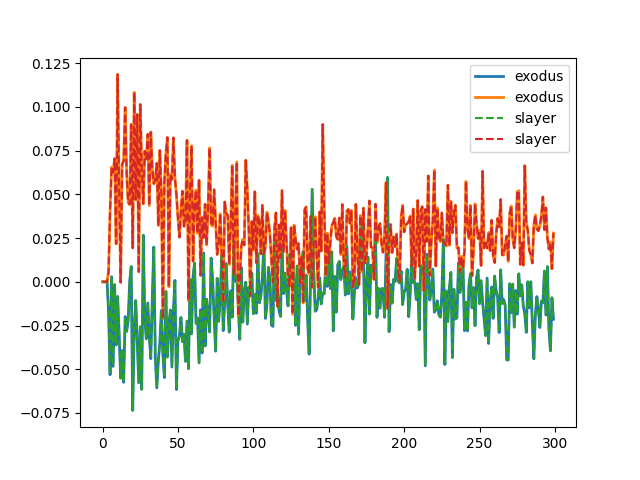

In [7]:
os = outputs_slayer[1].squeeze(0).cpu().detach()
oe = outputs_exodus[1].squeeze(0).cpu().detach()
plt.figure()
plt.plot(oe.t(), lw=2, label="exodus")
plt.plot(os.t(), ls="--", label="slayer")
plt.legend()
plt.show()

Outputs seem very similar.

In [8]:
# - Set up training
loss_func = torch.nn.CrossEntropyLoss()
optim_exo = optimizer_class(model_exodus.parameters(), lr=lr)
optim_slr = optimizer_class(model_slayer.parameters(), lr=lr)

# - Do a single batch

dl_iter = iter(dl)
inp, tgt, onehot = next(dl_iter)
print("Target:", tgt)
inp = inp.cuda()

# Sinabs
out_exo = model_exodus(inp).sum(-1).cpu()
optim_exo.zero_grad()
loss_exo = loss_func(out_exo, tgt)
loss_exo.backward()
grads_exo = [p.grad for p in model_exodus.parameters()]
model_exodus.reset()

# Slayer
out_slr = model_slayer(inp).sum(-1).cpu()
optim_slr.zero_grad()
loss_slr = loss_func(out_slr, tgt)
loss_slr.backward()
grads_slr = [p.grad.squeeze(-1) for p in model_slayer.parameters() if p.grad is not None]

print(f"Losses - Sinabs: {loss_exo.item()}, Slayer: {loss_slr.item()}")

Target: tensor([0])
Losses - Sinabs: 15.533903121948242, Slayer: 15.533878326416016


In [9]:
def correlation(a, b, eps=1e-16):
    a = a.flatten()
    b= b.flatten()
    return torch.sum(a*b) / (torch.sqrt(torch.sum(a**2) * torch.sum(b**2)) + eps)

In [10]:
print("Max gradients")
print("\tExodus:", [torch.max(g).item() for g in grads_exo])
print("\tSlayer:", [torch.max(g).item() for g in grads_slr])

print("Gradient std")
print("\tExodus:", [torch.std(g).item() for g in grads_exo])
print("\tSlayer:", [torch.std(g).item() for g in grads_slr])

print("Correlations")
print([correlation(gs, ge).item() for gs, ge in zip(grads_slr, grads_exo)])

Max gradients
	Exodus: [25.454816818237305, 32.2883415222168, 25.0]
	Slayer: [74755.6484375, 3456.594482421875, 24.999998092651367]
Gradient std
	Exodus: [8.930744171142578, 5.558072090148926, 7.7867841720581055]
	Slayer: [19171.474609375, 564.7001953125, 7.786783218383789]
Correlations
[0.8724439144134521, 0.9697255492210388, 1.0]


It turns out that with the default scaling (`kwargs_spiking["scale_grads"] = 1.0`), the gradients in the slayer model explode. After trying a few values, setting the scale to 0.02 seems to give reasonable gradients.
Let's train both models to see, whether everything works now.

In [11]:
# - Training loop

mistakes_exo = []
mistakes_slr = []

for ep in range(num_epochs):
    print(f"Epoch {ep} ------------------------------------------------------")
    for inp, tgt, __ in dl:
        inp = inp.cuda()       
        
        # Sinabs
        out_exo = model_exodus(inp).sum(-1).cpu()
        __, predict_exo = torch.max(out_exo, 1)
        optim_exo.zero_grad()
        loss_exo = loss_func(out_exo, tgt)
        loss_exo.backward()
        exo_right = tgt.item() == predict_exo.item()
        mistakes_exo.append(int(not exo_right))

        # Slayer
        out_slr = model_slayer(inp).sum(-1).cpu()
        __, predict_slr = torch.max(out_slr, 1)
        optim_slr.zero_grad()
        loss_slr = loss_func(out_slr, tgt)
        loss_slr.backward()        
        slr_right = tgt.item() == predict_slr.item()
        mistakes_slr.append(int(not slr_right))
        
        # Get correlation
        grads_exo = [p.grad.squeeze(-1) for p in model_exodus.parameters() if p.grad is not None]
        grads_slr = [p.grad.squeeze(-1) for p in model_slayer.parameters() if p.grad is not None]
        correls = [correlation(gs, ge).item() for gs, ge in zip(grads_slr, grads_exo)]
        
        # Optimizer step
        optim_exo.step()
        model_exodus.reset()
        optim_slr.step()
        
        # Print statement
        print(f"Target: {tgt.item()}")
        print(f"Prediction exodus: {predict_exo.item()} ({'correct' if exo_right else 'wrong'})")
        print(f"Prediction slayer: {predict_slr.item()} ({'correct' if slr_right else 'wrong'})")
        print(f"Gradient correlation: {correls}")
                
    # print(ep, sum(tl[-5:]), end="\r")
    print(f"Total mistakes exodus: {sum(mistakes_exo)}, slayer: {sum(mistakes_slr)} -----------------------")

Epoch 0 ------------------------------------------------------
Target: 1
Prediction exodus: 1 (correct)
Prediction slayer: 1 (correct)
Gradient correlation: [0.7955929040908813, 0.9435559511184692, 1.0]
Target: 0
Prediction exodus: 1 (wrong)
Prediction slayer: 1 (wrong)
Gradient correlation: [0.8732512593269348, 0.9690689444541931, 0.9999262094497681]
Total mistakes exodus: 1, slayer: 1 -----------------------
Epoch 1 ------------------------------------------------------
Target: 0
Prediction exodus: 0 (correct)
Prediction slayer: 0 (correct)
Gradient correlation: [0.0, 0.0, 0.0]
Target: 1
Prediction exodus: 0 (wrong)
Prediction slayer: 0 (wrong)
Gradient correlation: [-0.07029055804014206, 0.13404905796051025, 0.7214850783348083]
Total mistakes exodus: 2, slayer: 2 -----------------------
Epoch 2 ------------------------------------------------------
Target: 0
Prediction exodus: 1 (wrong)
Prediction slayer: 1 (wrong)
Gradient correlation: [0.02706049755215645, -0.07703103870153427, 0.

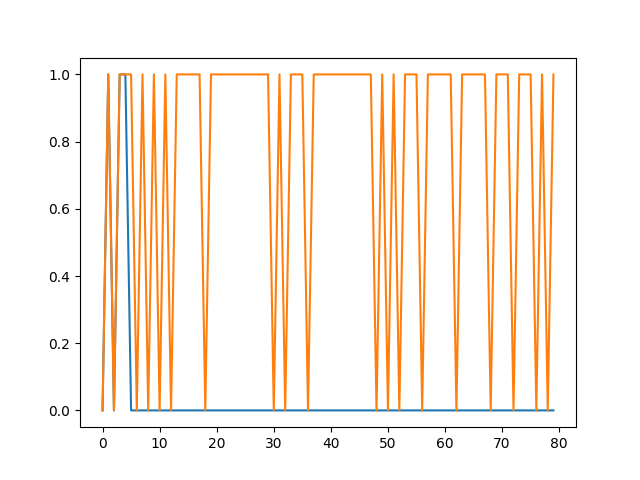

In [12]:
plt.figure()
plt.plot(mistakes_exo)
plt.plot(mistakes_slr)